In [120]:
import sys
sys.path.append('/Users/laurenthericourt/projets/trading/trading')

import psycopg2
import pandas as pd
from pandas.io.sql import read_sql
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt

from config.load import load_conf
from db.utils import get_uri_db
from strategy.examples.ema200_multitimeframes import Ema200MultiTimeframes
from strategy.examples.ema5_ema12_rsi21 import Ema5Ema12Rsi21
from strategy.examples.triangular_rsi import TriRSI
from strategy.examples.ks_envelopes import KsEnvelopes
from strategy.stop_loss import StopLossATR, StopLossFix, StopLossWithConstraint
from utils.utils import AnnualGranularity, get_candles

In [2]:
load_conf('../config/configuration.yaml')
dsn = get_uri_db()
schema = 'trading'

# Get data

In [96]:
start_date = '2010-01-01'
end_date = '2021-01-01'

candles = get_candles(dsn, schema, start_date, end_date)

In [4]:
candles.head()

,table,date,symbol,open,close,low,high,tickqty
0,candle,2018-01-01 20:00:00,AUD/USD,0.78099,0.78044,0.78044,0.78099,2
1,candle,2018-01-01 20:05:00,AUD/USD,0.78044,0.78044,0.78044,0.78044,2
2,candle,2018-01-01 21:20:00,AUD/USD,0.78044,0.78092,0.78044,0.78092,6
3,candle,2018-01-01 21:25:00,AUD/USD,0.78092,0.78130,0.78086,0.78130,12
4,candle,2018-01-01 21:30:00,AUD/USD,0.78130,0.78083,0.78064,0.78130,35


# Test_strategy
# On currency pair

In [27]:
candles['symbol'].unique()

array(['AUD/USD', 'EUR/GBP', 'EUR/USD', 'GBP/USD', 'USD/CAD', 'USD/CHF',
       'USD/HKD', 'USD/JPY'], dtype=object)

In [101]:
mask = (candles['table'].isin(['candle1h', 'candle4h', 'candle1d'])) & (candles['symbol'] == 'USD/CHF')
mask = (candles['table'] == 'candle1h') & (candles['symbol'] == 'EUR/USD')
candles_EURUSD = candles[mask]

In [102]:
#strat = Ema200MultiTimeframes(candles_EURUSD, AnnualGranularity.MIN_30.value, stop_loss_pips=1e-1, take_profits_pips=5e-2)

In [103]:
#stoploss = StopLossFix(stop=5e-4, profit=5e-3)
stoploss = StopLossATR(stop=1, profit=2)
#stoploss = StopLossWithConstraint(column='ema200_1h')

In [104]:
strat = TriRSI(candles_EURUSD, AnnualGranularity.MIN_30.value, stoploss)

In [105]:
actions = strat.apply_strategy(update_stop_loss=False)

In [109]:
strat.data.tail()

,table,date,symbol,open,close,low,high,tickqty,rsi_1,rsi_2,rsi_3,action,action_price,ret,stop_loss,take_profit,return,return_cumsum
69288,candle1h,2020-12-31 15:00:00,EUR/USD,1.22701,1.22393,1.22256,1.22712,24762,17.676469,34.568419,17.676469,1,1.223930,0.000000,1.222137,1.227517,0.000000,-2279.249968
69289,candle1h,2020-12-31 16:00:00,EUR/USD,1.22393,1.22308,1.22218,1.22411,19851,15.200101,33.117806,15.200101,0,1.223080,-0.000850,1.222137,1.227517,-85.000000,-2364.249968
69290,candle1h,2020-12-31 17:00:00,EUR/USD,1.22307,1.22255,1.22223,1.22351,11657,13.703773,32.100377,13.703773,0,1.222550,-0.000520,1.222137,1.227517,-52.000000,-2416.249968
69291,candle1h,2020-12-31 18:00:00,EUR/USD,1.22255,1.22176,1.22156,1.22289,6998,11.579826,30.441062,11.579826,-1,1.222137,-0.000413,0.000000,0.000000,-41.327484,-2457.577453
69292,candle1h,2020-12-31 19:00:00,EUR/USD,1.22175,1.22169,1.22162,1.22178,223,11.384395,30.261148,11.384395,0,1.221690,0.000000,0.000000,0.000000,0.000000,-2457.577453


In [110]:
strat.data['return_cumsum'] = strat.data['return_cumsum'].abs()

<AxesSubplot:>

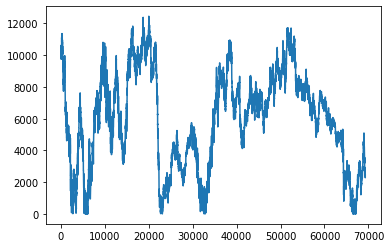

In [112]:
#strat.compute_return()
strat.data['return_cumsum'].plot()

In [111]:
strat.granularity = AnnualGranularity.H_1.value
strat.compute_performance()
pd.DataFrame.from_dict(strat.indicators, orient='index')

,0
CAGR,-0.12
Volatility,186.09
SharpeRatio,-0.00
Calmar,-0.03
RiskRewardRatio,2.00
BreakevenHitRatio,33.30
NbTrades,4364.00
HitRatio,33.00
Expectancy,-3.02
ProfitFactor,0.98


In [69]:
strat.indicators

{'CAGR': 1.17,
 'Volatility': 2034.76,
 'SharpeRatio': 0.0,
 'Calmar': -0.27,
 'RiskRewardRatio': 2.0,
 'BreakevenHitRatio': 33.3,
 'NbTrades': 2342,
 'HitRatio': 33.8,
 'Expectancy': 39.16,
 'ProfitFactor': 1.01}

## Several currency pairs

In [ ]:
AnnualGranularity.H

In [137]:
from strategy.strategy import StrategyAbstract, StrategyAction
from indicator.trend import MovingAverage


class KsEnvelopes(StrategyAbstract):
    def apply_strategy(self, update_stop_loss=False):
        self.data = self.data.copy()
        ma_high = MovingAverage(self.data, 'high')
        self.data['ma_high'] = ma_high.compute(span=700)

        ma_low = MovingAverage(self.data, 'low')
        self.data['ma_low'] = ma_low.compute(span=700)

        self.data.dropna(axis=0, inplace=True)
        self.data.reset_index(drop=True, inplace=True)

        self._reinit_data()
        self.stop_loss.data = self.data

        prev_row = None
        in_ma_zone = False
        for row in self.data.itertuples(index=True):
            if prev_row is None:
                self._process_first_trade(row)
            elif self.position == StrategyAction.DO_NOTHING.value:
                if not in_ma_zone and row.close > row.ma_low and row.close < row.ma_high:
                    in_ma_zone = True
                    self._take_no_position(row)
                elif in_ma_zone and row.close > row.ma_high:
                    in_ma_zone = False
                    stop_loss, take_profit = self.stop_loss.compute(row.Index, row.close, buy_action=True)
                    self._take_buy(row, row.close, stop_loss, take_profit)
                elif in_ma_zone and row.close < row.ma_low:
                    in_ma_zone = False
                    stop_loss, take_profit = self.stop_loss.compute(row.Index, row.close, buy_action=False)
                    self._take_sell(row, row.close, stop_loss, take_profit)
                else:
                    self._take_no_position(row)
            else:
                action, action_price, ret, self.position, take_profit, stop_loss = self._quit_position(self.position, row, take_profit, stop_loss, update_stop_loss)
                self._add_one_result_step(action, action_price, ret, take_profit, stop_loss)

            prev_row = row

        self._save_strategy_result()



In [142]:
currencies = ['AUD/USD', 'EUR/GBP', 'EUR/USD', 'GBP/USD', 'USD/CAD', 'USD/CHF']

currencies = ['AUD/USD', 'EUR/GBP', 'EUR/USD', 'GBP/USD', 'USD/CHF']
returns = list()
perf = list()
timeframe = 'candle1h'
for cur in currencies:
    print(cur)
    mask = (candles['table'] == timeframe) & (candles['symbol'] == cur)
    candles_tmp = candles[mask]
    stoploss = StopLossATR(stop=1, profit=2)
    strat = KsEnvelopes(candles_tmp, AnnualGranularity.H_1.value, stoploss)
    actions = strat.apply_strategy(update_stop_loss=False)
    strat.compute_return()
    returns.append(strat.data['return_cumsum'])
    
    strat.granularity = AnnualGranularity.MIN_30.value
    strat.compute_performance()
    perf.append(strat.indicators)
    
    

AUD/USD
EUR/GBP
EUR/USD
GBP/USD
USD/CHF


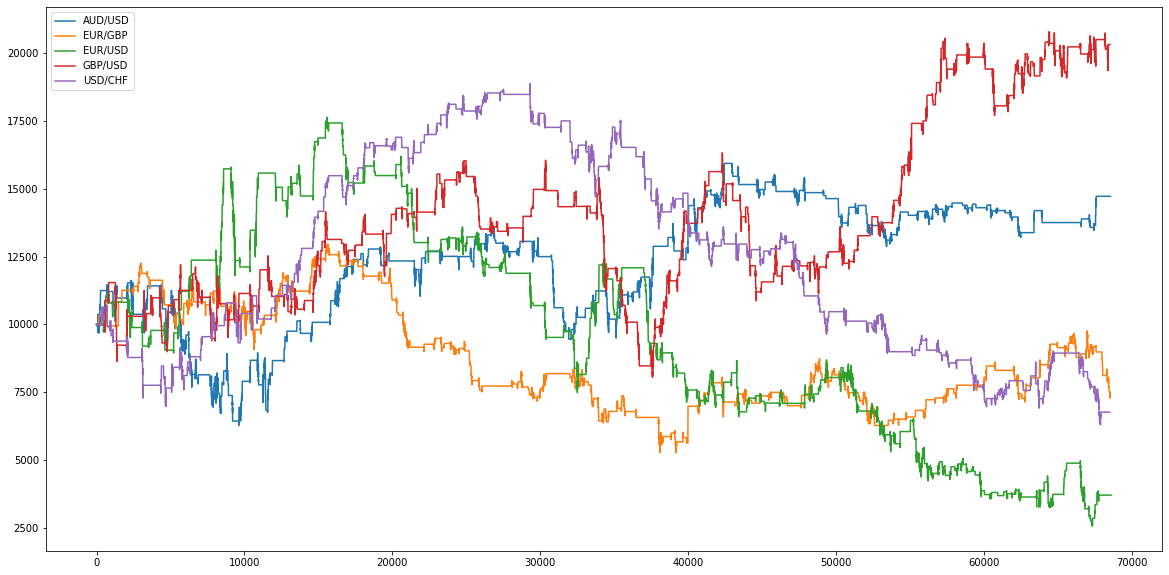

In [143]:
plt.figure(figsize=(20,10))
for cur, data in zip(currencies, returns):
    plt.plot(data, label=cur)
plt.legend(loc="upper left")
plt.show()

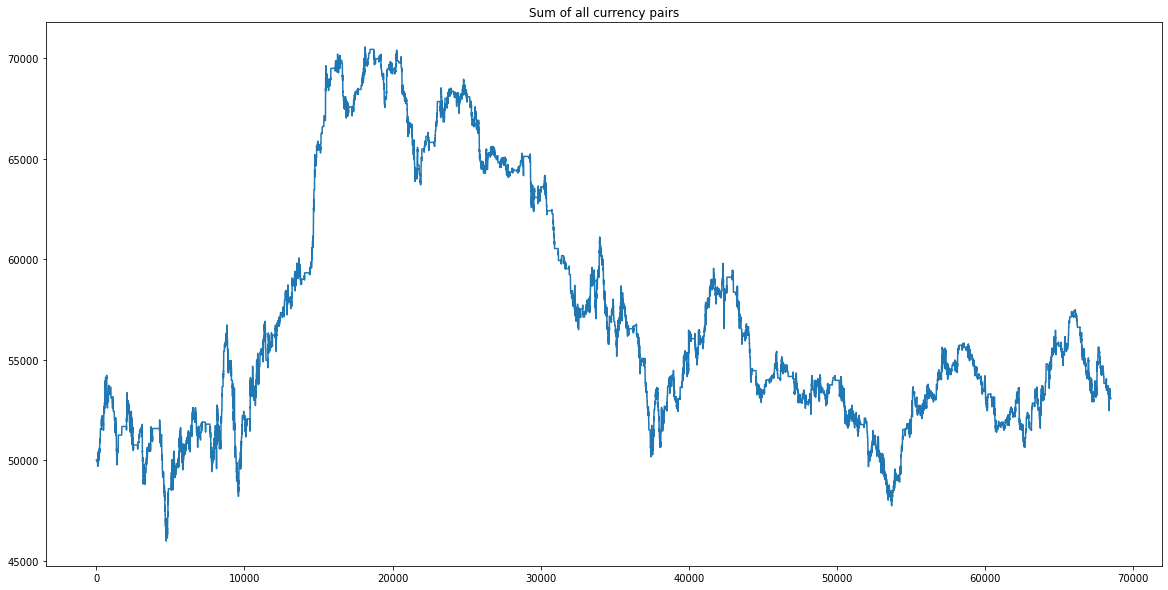

In [144]:
plt.figure(figsize=(20,10))
plt.plot(pd.DataFrame(returns).dropna(axis=1).sum(axis=0))
plt.title('Sum of all currency pairs')
plt.show()

In [141]:
pd.DataFrame(perf, index=currencies)

,CAGR,Volatility,SharpeRatio,Calmar,RiskRewardRatio,BreakevenHitRatio,NbTrades,HitRatio,Expectancy,ProfitFactor
AUD/USD,0.05,0.51,0.09,-0.06,4.0,20.0,640,20.3,4.90,1.04
EUR/GBP,0.00,0.53,-0.01,0.00,4.0,20.0,621,19.0,0.27,1.00
EUR/USD,-0.25,33.43,-0.01,-0.07,4.0,20.0,655,17.9,-12.53,0.91
GBP/USD,0.12,0.68,0.17,-0.06,4.0,20.0,602,20.6,14.12,1.08
USD/CHF,-0.34,0.56,-0.62,-0.08,4.0,20.0,643,18.8,-14.39,0.89


# Show some data

In [13]:
strat.data[strat.data['action'] == 1].shape

(11, 18)

In [29]:
strat.data.head(20)

,table,date,symbol,open,close,low,high,tickqty,rsi_1,rsi_2,rsi_3,action,action_price,ret,stop_loss,take_profit,return,return_cumsum
0,candle1d,2018-01-18,EUR/USD,1.21813,1.22350,1.21742,1.22656,315013,64.538561,41.645672,42.425876,0,1.22350,0.00000,0.0,0.0,10000.0,10000.0
1,candle1d,2018-01-19,EUR/USD,1.22350,1.22200,1.22155,1.22962,290654,60.651088,37.990214,38.531212,0,1.22200,0.00000,0.0,0.0,0.0,10000.0
2,candle1d,2018-01-21,EUR/USD,1.22200,1.22568,1.22200,1.22757,10731,66.786328,47.142915,52.034384,0,1.22568,0.00000,0.0,0.0,0.0,10000.0
3,candle1d,2018-01-22,EUR/USD,1.22568,1.22571,1.22147,1.22679,239671,66.839016,47.226532,52.141517,0,1.22571,0.00000,0.0,0.0,0.0,10000.0
4,candle1d,2018-01-23,EUR/USD,1.22571,1.23096,1.22237,1.23161,300121,75.381767,60.038804,67.849716,0,1.23096,0.00000,0.0,0.0,0.0,10000.0
5,candle1d,2018-01-24,EUR/USD,1.23096,1.23934,1.22920,1.24157,379020,83.739634,69.187272,80.572446,-1,1.23934,0.00000,NaN,NaN,0.0,10000.0
6,candle1d,2018-01-25,EUR/USD,1.23958,1.23919,1.23648,1.25387,669978,83.108327,67.723398,79.865297,0,1.23919,0.00039,NaN,NaN,39.0,10039.0
7,candle1d,2018-01-26,EUR/USD,1.23919,1.24334,1.23871,1.24945,459699,86.601578,71.843893,84.553623,0,1.24334,-0.00415,NaN,NaN,-415.0,9624.0
8,candle1d,2018-01-28,EUR/USD,1.24334,1.24320,1.24143,1.24396,6825,85.852888,69.467991,83.731472,0,1.24320,0.00014,NaN,NaN,14.0,9638.0
9,candle1d,2018-01-29,EUR/USD,1.24320,1.23816,1.23374,1.24330,365961,61.807577,29.844943,58.245798,0,1.23816,0.00504,NaN,NaN,504.0,10142.0


In [14]:
strat.data.loc[:20, ['close', 'low', 'high', 'hist_macd', 'action', 'stop_loss', 'take_profit', 'ret', 'return_cumsum']]

,close,low,high,hist_macd,action,stop_loss,take_profit,ret,return_cumsum
0,1.13007,1.12817,1.13089,-4.818364e-04,0,0.00000,0.00000,0.00000,10000.0
1,1.12770,1.12688,1.13164,-6.256687e-04,0,0.00000,0.00000,0.00000,10000.0
2,1.12893,1.12763,1.13193,-6.314974e-04,0,0.00000,0.00000,0.00000,10000.0
3,1.12978,1.12861,1.13092,-5.728108e-04,0,0.00000,0.00000,0.00000,10000.0
4,1.13047,1.12902,1.13058,-4.850376e-04,0,0.00000,0.00000,0.00000,10000.0
5,1.12879,1.12847,1.13156,-5.248817e-04,0,0.00000,0.00000,0.00000,10000.0
6,1.12674,1.12558,1.12968,-6.634062e-04,0,0.00000,0.00000,0.00000,10000.0
7,1.12825,1.12415,1.12852,-6.384372e-04,0,0.00000,0.00000,0.00000,10000.0
8,1.13481,1.12802,1.13643,-2.024143e-04,0,0.00000,0.00000,0.00000,10000.0
9,1.13372,1.13333,1.13549,-4.350403e-07,0,0.00000,0.00000,0.00000,10000.0


In [60]:
strat.data['%50'] = strat.data.apply(axis=1, func=lambda x: int(x['return_cumsum'] % 50))

In [ ]:
strat.data

In [9]:
mask = (strat.data['high'] >= strat.data['previous_roll_max'])
strat.data[mask]

,table,date,symbol,open,close,low,high,tickqty,atr,roll_max,roll_min,roll_max_vol,previous_table,previous_date,previous_symbol,previous_open,previous_close,previous_low,previous_high,previous_tickqty,previous_atr,previous_roll_max,previous_roll_min,previous_roll_max_vol,action
949606,candle1d,2020-02-28,EUR/USD,1.09970,1.10300,1.09516,1.10536,418308,0.005080,1.10536,1.07785,418308.0,candle1d,2020-02-27,EUR/USD,1.08870,1.09970,1.08854,1.10072,331934.0,0.004841,1.10486,1.07785,331934.0,0
949607,candle1d,2020-03-01,EUR/USD,1.10300,1.10525,1.10300,1.10745,16988,0.005054,1.10745,1.07785,418308.0,candle1d,2020-02-28,EUR/USD,1.09970,1.10300,1.09516,1.10536,418308.0,0.005080,1.10536,1.07785,418308.0,0
949608,candle1d,2020-03-02,EUR/USD,1.10525,1.11449,1.10370,1.11853,486031,0.005580,1.11853,1.07785,486031.0,candle1d,2020-03-01,EUR/USD,1.10300,1.10525,1.10300,1.10745,16988.0,0.005054,1.10745,1.07785,418308.0,0
949609,candle1d,2020-03-03,EUR/USD,1.11449,1.11772,1.10958,1.12140,509082,0.006132,1.12140,1.07785,509082.0,candle1d,2020-03-02,EUR/USD,1.10525,1.11449,1.10370,1.11853,486031.0,0.005580,1.11853,1.07785,486031.0,0
949611,candle1d,2020-03-05,EUR/USD,1.11390,1.12233,1.11202,1.12458,307027,0.006802,1.12458,1.07785,509082.0,candle1d,2020-03-04,EUR/USD,1.11772,1.11390,1.10961,1.11881,342226.0,0.006343,1.12140,1.07785,509082.0,0
949612,candle1d,2020-03-06,EUR/USD,1.12233,1.12892,1.12113,1.13553,580869,0.007220,1.13553,1.07785,580869.0,candle1d,2020-03-05,EUR/USD,1.11390,1.12233,1.11202,1.12458,307027.0,0.006802,1.12458,1.07785,509082.0,0
949613,candle1d,2020-03-08,EUR/USD,1.12892,1.13884,1.12892,1.13974,50591,0.007488,1.13974,1.07785,580869.0,candle1d,2020-03-06,EUR/USD,1.12233,1.12892,1.12113,1.13553,580869.0,0.007220,1.13553,1.07785,580869.0,0
949614,candle1d,2020-03-09,EUR/USD,1.13884,1.13999,1.13568,1.14974,956742,0.008021,1.14974,1.07785,956742.0,candle1d,2020-03-08,EUR/USD,1.12892,1.13884,1.12892,1.13974,50591.0,0.007488,1.13974,1.07785,580869.0,0
949660,candle1d,2020-05-01,EUR/USD,1.09456,1.09846,1.09352,1.10196,222060,0.007317,1.10196,1.07276,390717.0,candle1d,2020-04-30,EUR/USD,1.08779,1.09456,1.08335,1.09735,390717.0,0.007230,1.09922,1.07276,390717.0,0
949682,candle1d,2020-05-27,EUR/USD,1.09791,1.10174,1.09343,1.10315,420202,0.006810,1.10315,1.07672,420202.0,candle1d,2020-05-26,EUR/USD,1.09023,1.09791,1.08973,1.09966,241409.0,0.006650,1.10091,1.07672,292042.0,0


In [18]:
strat.data[strat.data['action'] != 0]

,table,date,symbol,open,close,low,high,tickqty,atr,roll_max,roll_min,roll_max_vol,previous_table,previous_date,previous_symbol,previous_open,previous_close,previous_low,previous_high,previous_tickqty,previous_atr,previous_roll_max,previous_roll_min,previous_roll_max_vol,action
148323,candle,2020-01-03 07:15:00,EUR/USD,1.11639,1.11614,1.11607,1.11650,1168,0.000228,1.11722,1.11607,1381.0,candle,2020-01-03 07:10:00,EUR/USD,1.11713,1.11639,1.11637,1.11720,1381.0,0.000220,1.11722,1.11637,1381.0,-1
148333,candle,2020-01-03 08:05:00,EUR/USD,1.11570,1.11577,1.11566,1.11587,944,0.000307,1.11722,1.11526,2158.0,candle,2020-01-03 08:00:00,EUR/USD,1.11539,1.11570,1.11526,1.11595,2158.0,0.000306,1.11722,1.11526,2158.0,1
148417,candle,2020-01-03 15:05:00,EUR/USD,1.11565,1.11591,1.11541,1.11608,1933,0.000426,1.11679,1.11359,4124.0,candle,2020-01-03 15:00:00,EUR/USD,1.11529,1.11565,1.11529,1.11679,4124.0,0.000400,1.11679,1.11359,4124.0,1
148464,candle,2020-01-03 19:00:00,EUR/USD,1.11679,1.11656,1.11651,1.11689,1080,0.000237,1.11742,1.11651,1408.0,candle,2020-01-03 18:55:00,EUR/USD,1.11689,1.11679,1.11666,1.11694,459.0,0.000231,1.11742,1.11666,1408.0,-1
148826,candle,2020-01-07 00:05:00,EUR/USD,1.11944,1.11956,1.11944,1.11960,420,0.000112,1.11982,1.11938,577.0,candle,2020-01-07 00:00:00,EUR/USD,1.11961,1.11944,1.11938,1.11962,577.0,0.000109,1.11982,1.11938,577.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221931,candle,2020-12-23 01:40:00,EUR/USD,1.21796,1.21794,1.21785,1.21813,837,0.000427,1.21856,1.21547,2470.0,candle,2020-12-23 01:35:00,EUR/USD,1.21751,1.21796,1.21741,1.21796,943.0,0.000435,1.21880,1.21547,2470.0,1
221996,candle,2020-12-23 07:05:00,EUR/USD,1.21848,1.21903,1.21844,1.21906,985,0.000223,1.21906,1.21800,1489.0,candle,2020-12-23 07:00:00,EUR/USD,1.21845,1.21848,1.21800,1.21852,1489.0,0.000197,1.21905,1.21800,1489.0,-1
221997,candle,2020-12-23 07:10:00,EUR/USD,1.21903,1.21898,1.21893,1.21926,891,0.000232,1.21926,1.21800,1489.0,candle,2020-12-23 07:05:00,EUR/USD,1.21848,1.21903,1.21844,1.21906,985.0,0.000223,1.21906,1.21800,1489.0,1
222163,candle,2020-12-23 21:00:00,EUR/USD,1.21960,1.21916,1.21911,1.21963,1063,0.000373,1.21973,1.21740,1442.0,candle,2020-12-23 20:55:00,EUR/USD,1.21876,1.21961,1.21876,1.21973,1442.0,0.000363,1.21973,1.21732,1442.0,1
